<a href="https://colab.research.google.com/github/MaYuetong/MaYuetong/blob/main/visualisatin_PARTICIPANTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
!pip install cartopy geopandas pandas matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])


<ipython-input-4-e726b3076624>:73: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {ur

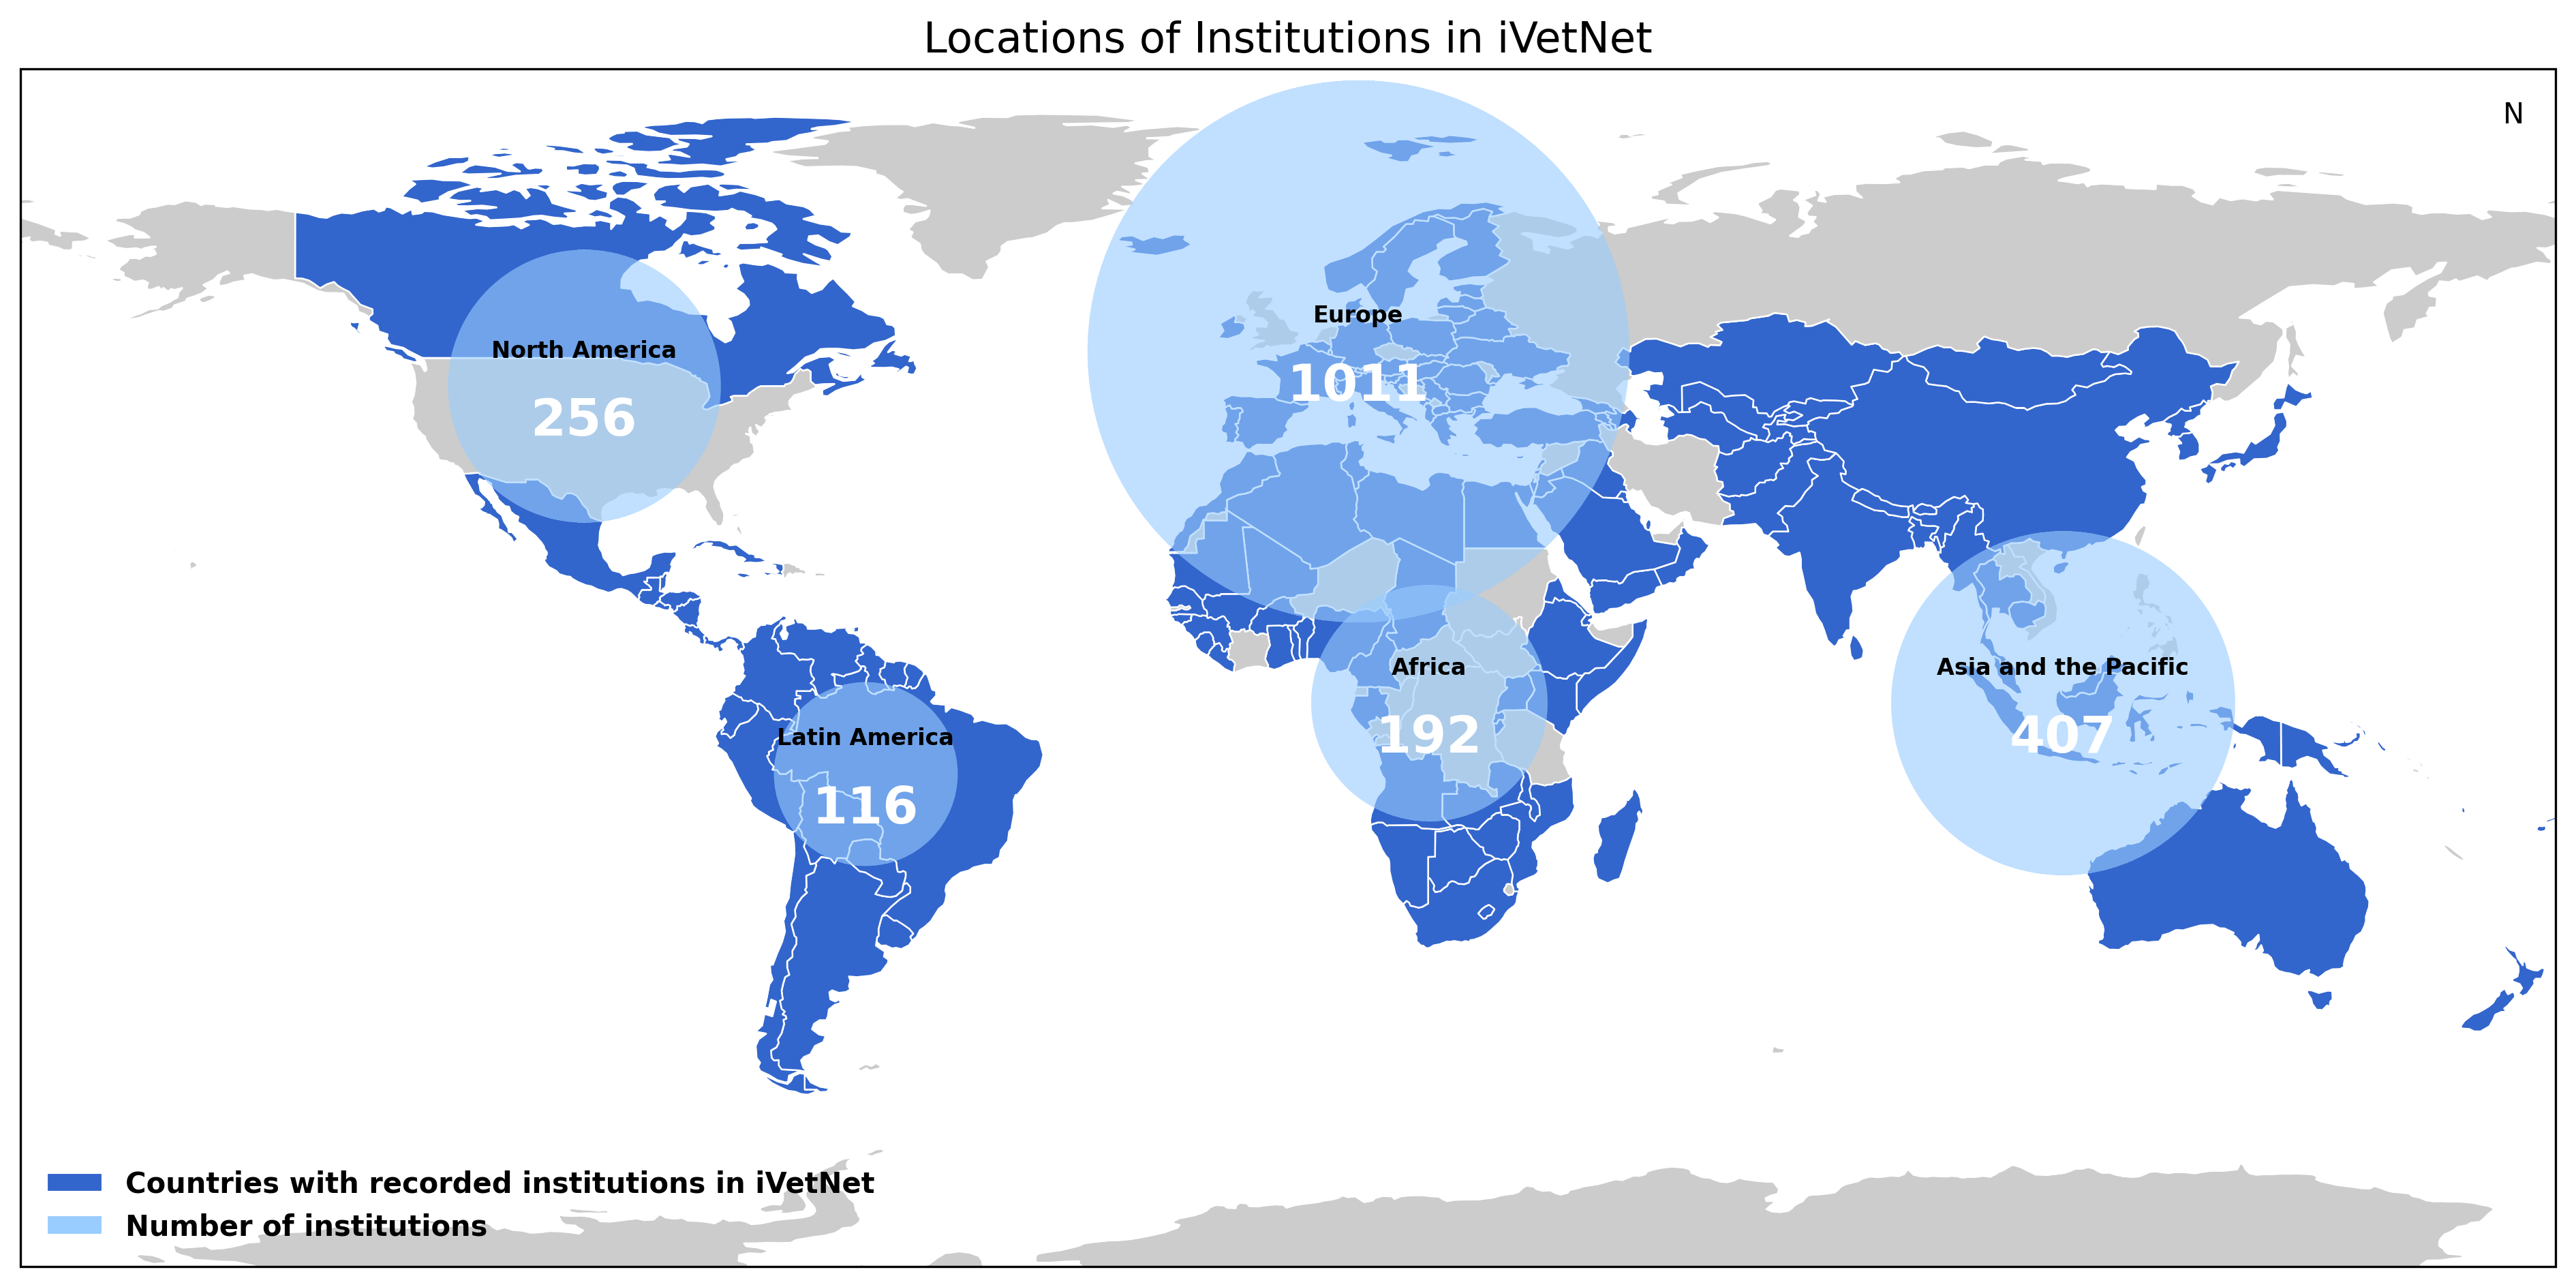

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text

bubble_color = '#99ccff'
text_color = 'black'
highlighted_country_color = '#3366cc'
default_country_color = '#cccccc'
text_color2 = 'white'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.6, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=8, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries with recorded institutions in iVetNet'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Locations of Institutions in iVetNet', size=15)
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# Show plot
plt.show()

<ipython-input-21-126f340c8a02>:77: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


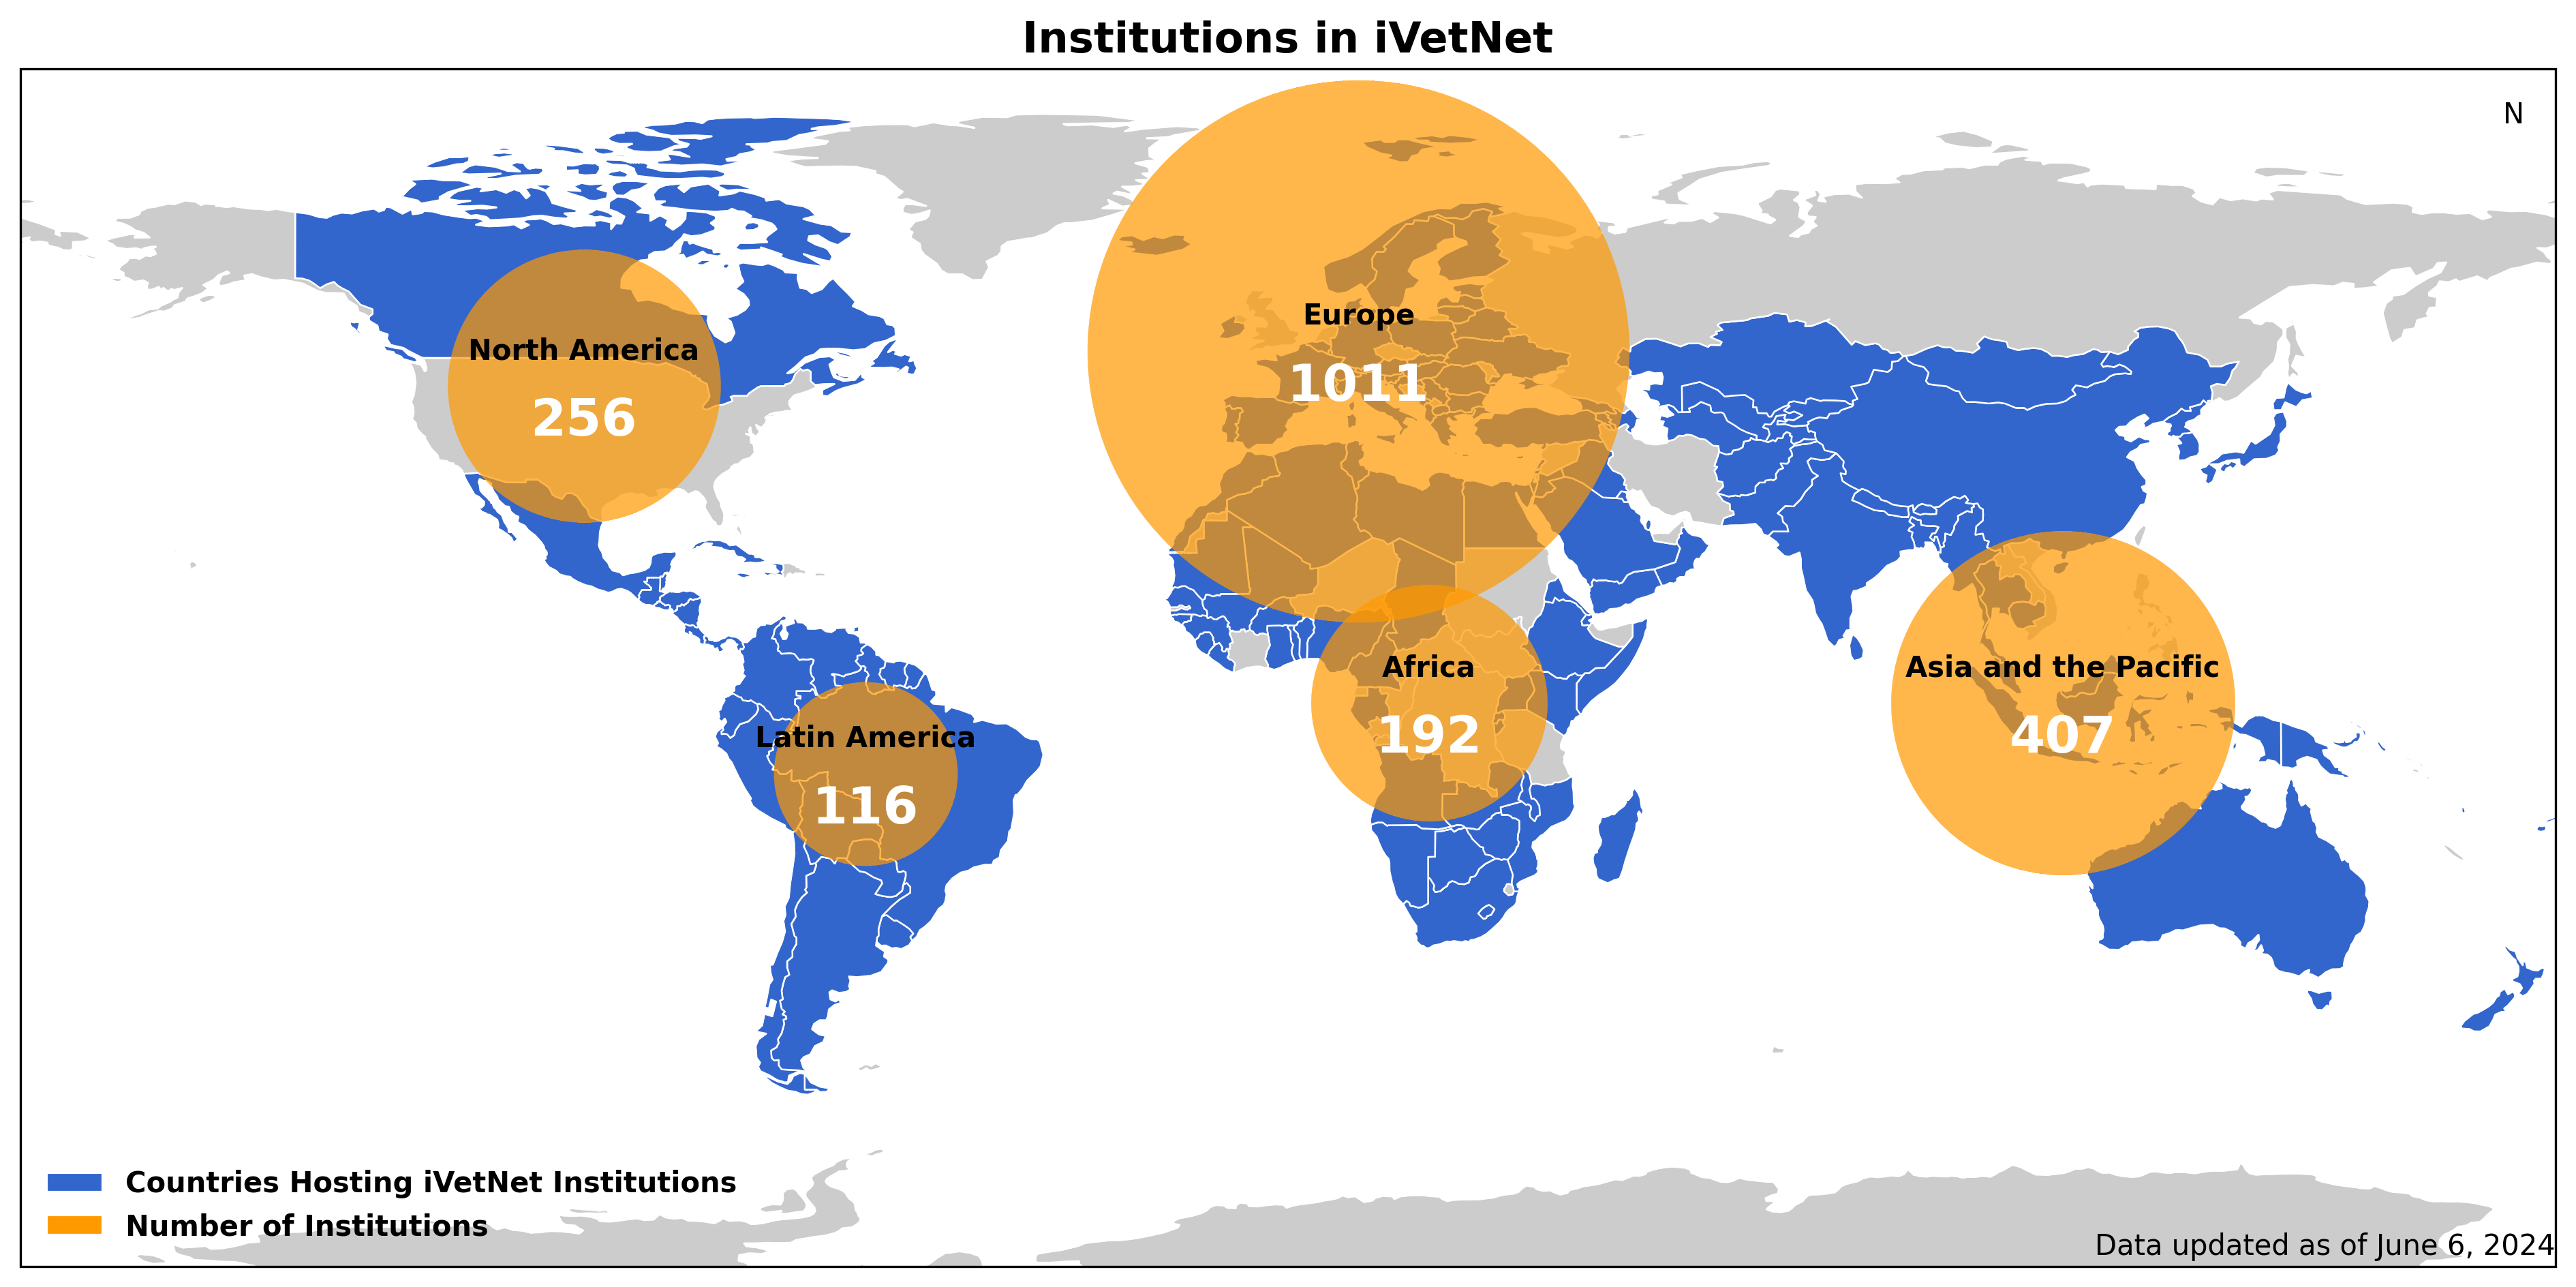

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text
#bubble_color = '#fcd3c1'
#text_color = '#e5a487'
#highlighted_country_color = '#c7c4e2'
#default_country_color = '#cccccc'

bubble_color = '#ff9900'
text_color = 'black'
highlighted_country_color = '#3366cc'
default_country_color = '#cccccc'
text_color2 = 'white'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.7, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=10, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries Hosting iVetNet Institutions'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of Institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Institutions in iVetNet', size=15, weight='bold')
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# 添加更新日期
update_text = 'Data updated as of June 6, 2024'
ax.text(1, 0.01, update_text, transform=ax.transAxes, fontsize=10, ha='right')


# save image
#plt.savefig('/content/drive/MyDrive/figures/locations_of_institutions1.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


<ipython-input-14-c4635e5790c9>:72: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


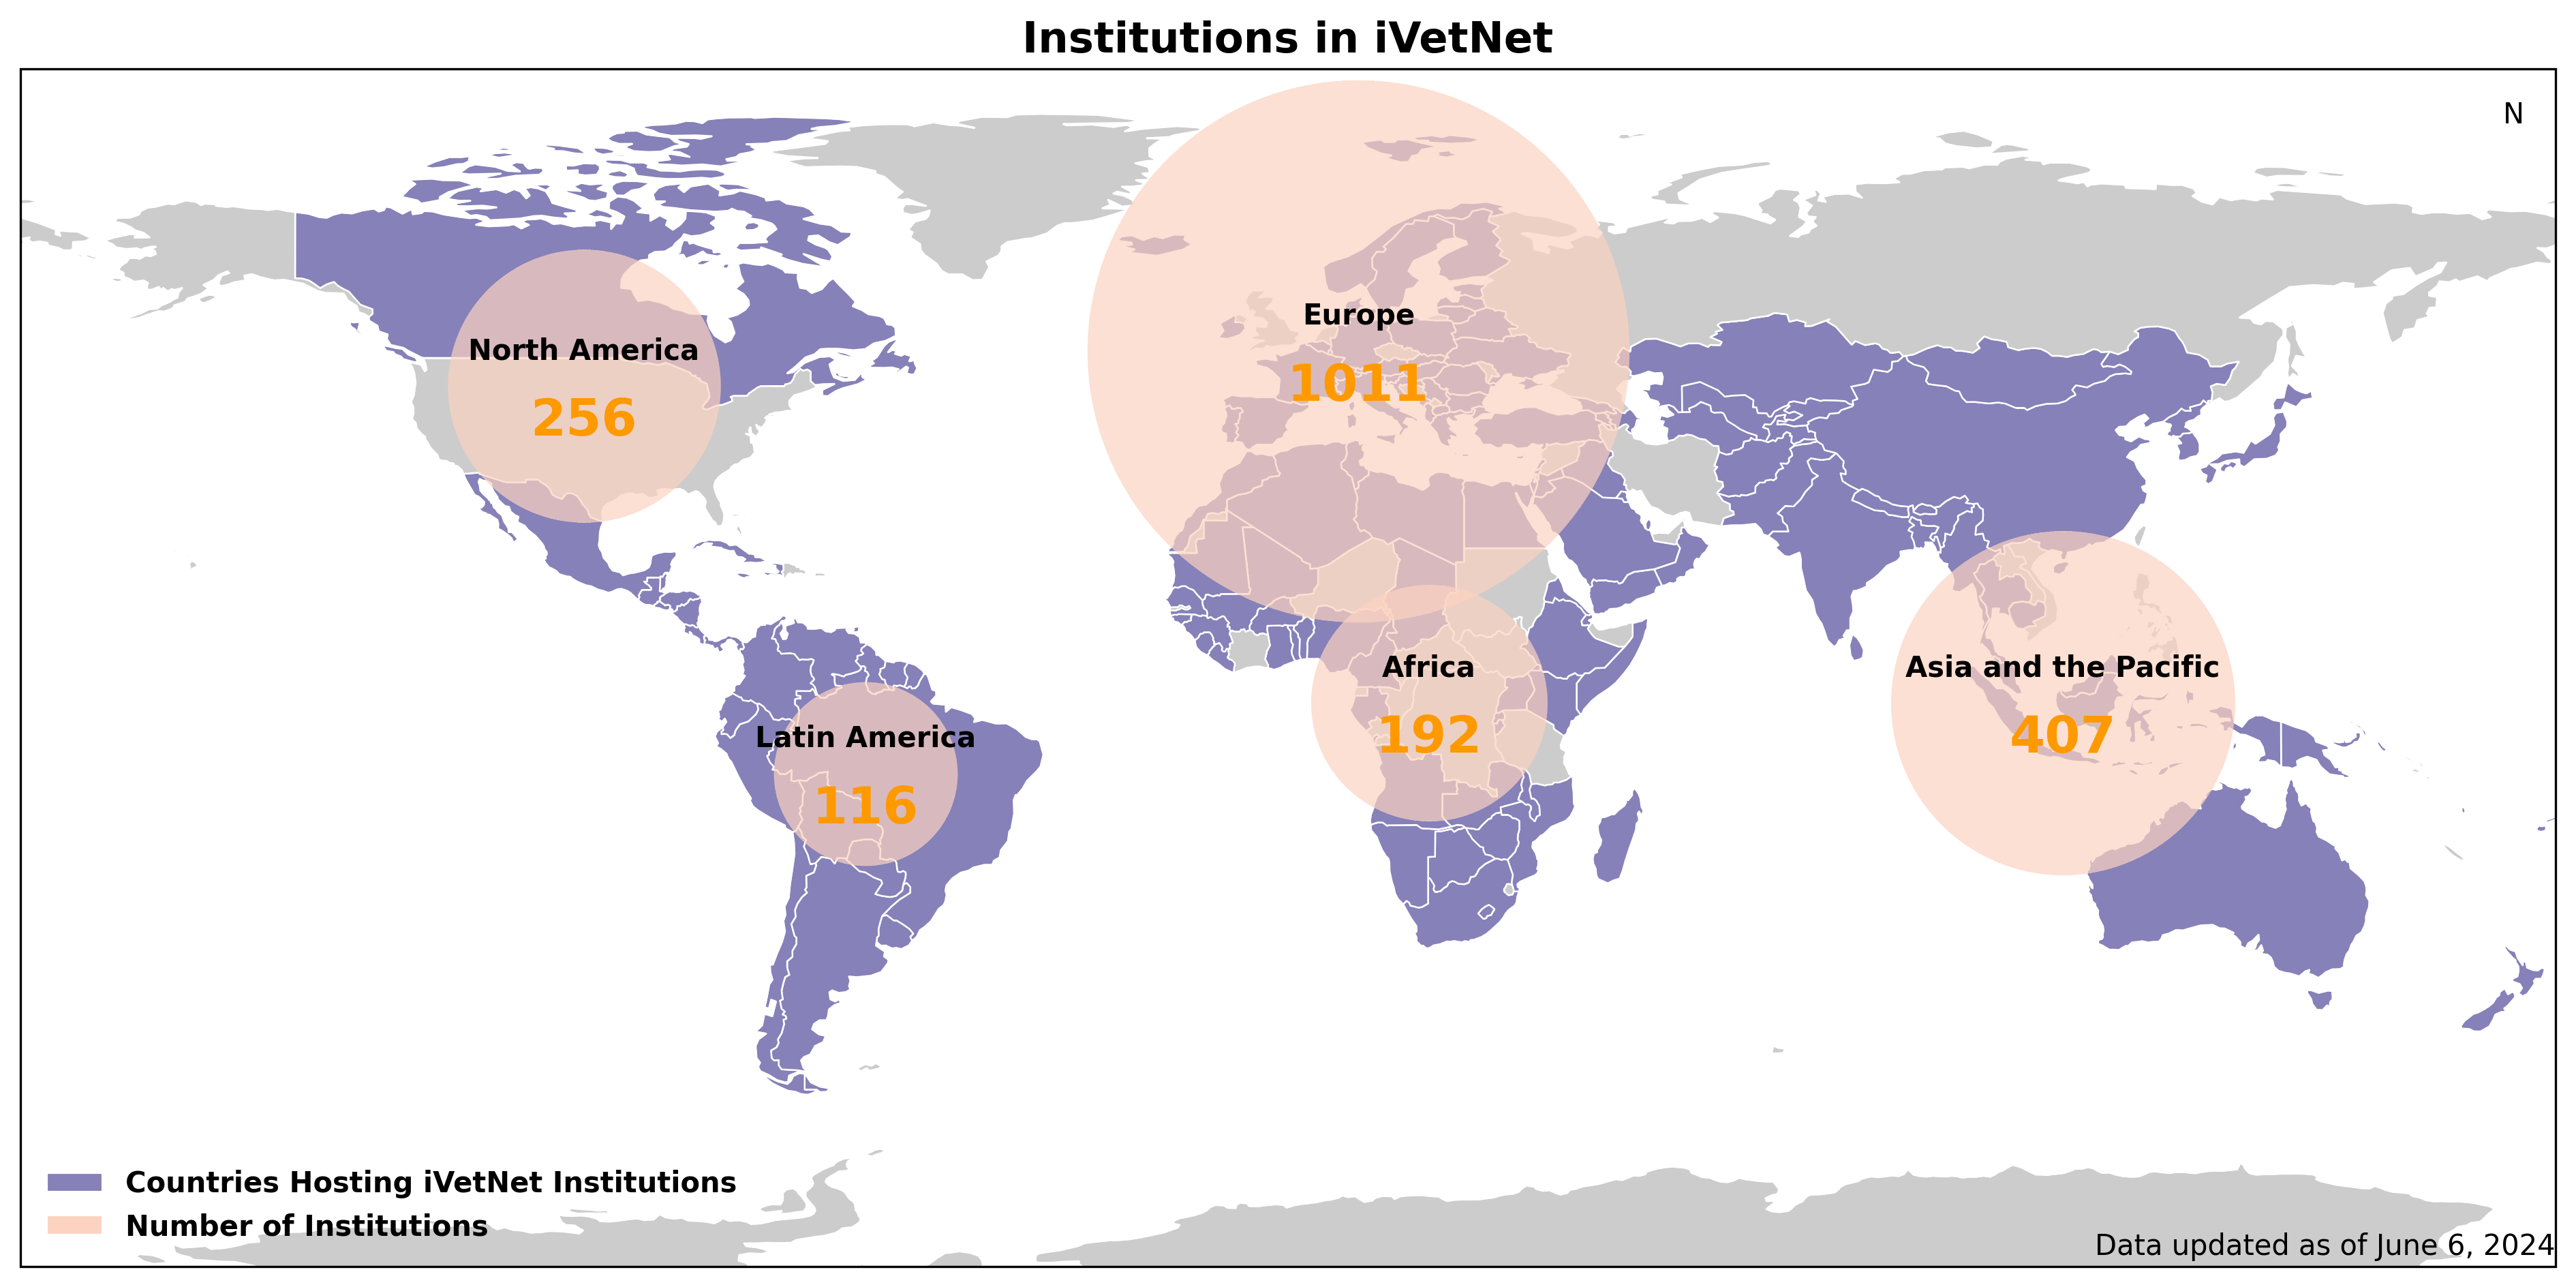

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text
bubble_color = '#fcd3c1'
text_color = 'black'
highlighted_country_color = '#8681b8'
default_country_color = '#cccccc'
text_color2 = '#ff9900'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.7, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=10, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries Hosting iVetNet Institutions'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of Institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Institutions in iVetNet', size=15, weight='bold')
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# 添加更新日期
update_text = 'Data updated as of June 6, 2024'
ax.text(1, 0.01, update_text, transform=ax.transAxes, fontsize=10, ha='right')


# save image
plt.savefig('/content/drive/MyDrive/figures/locations_of_institutions2.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


<ipython-input-19-fdf3b816cd60>:72: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


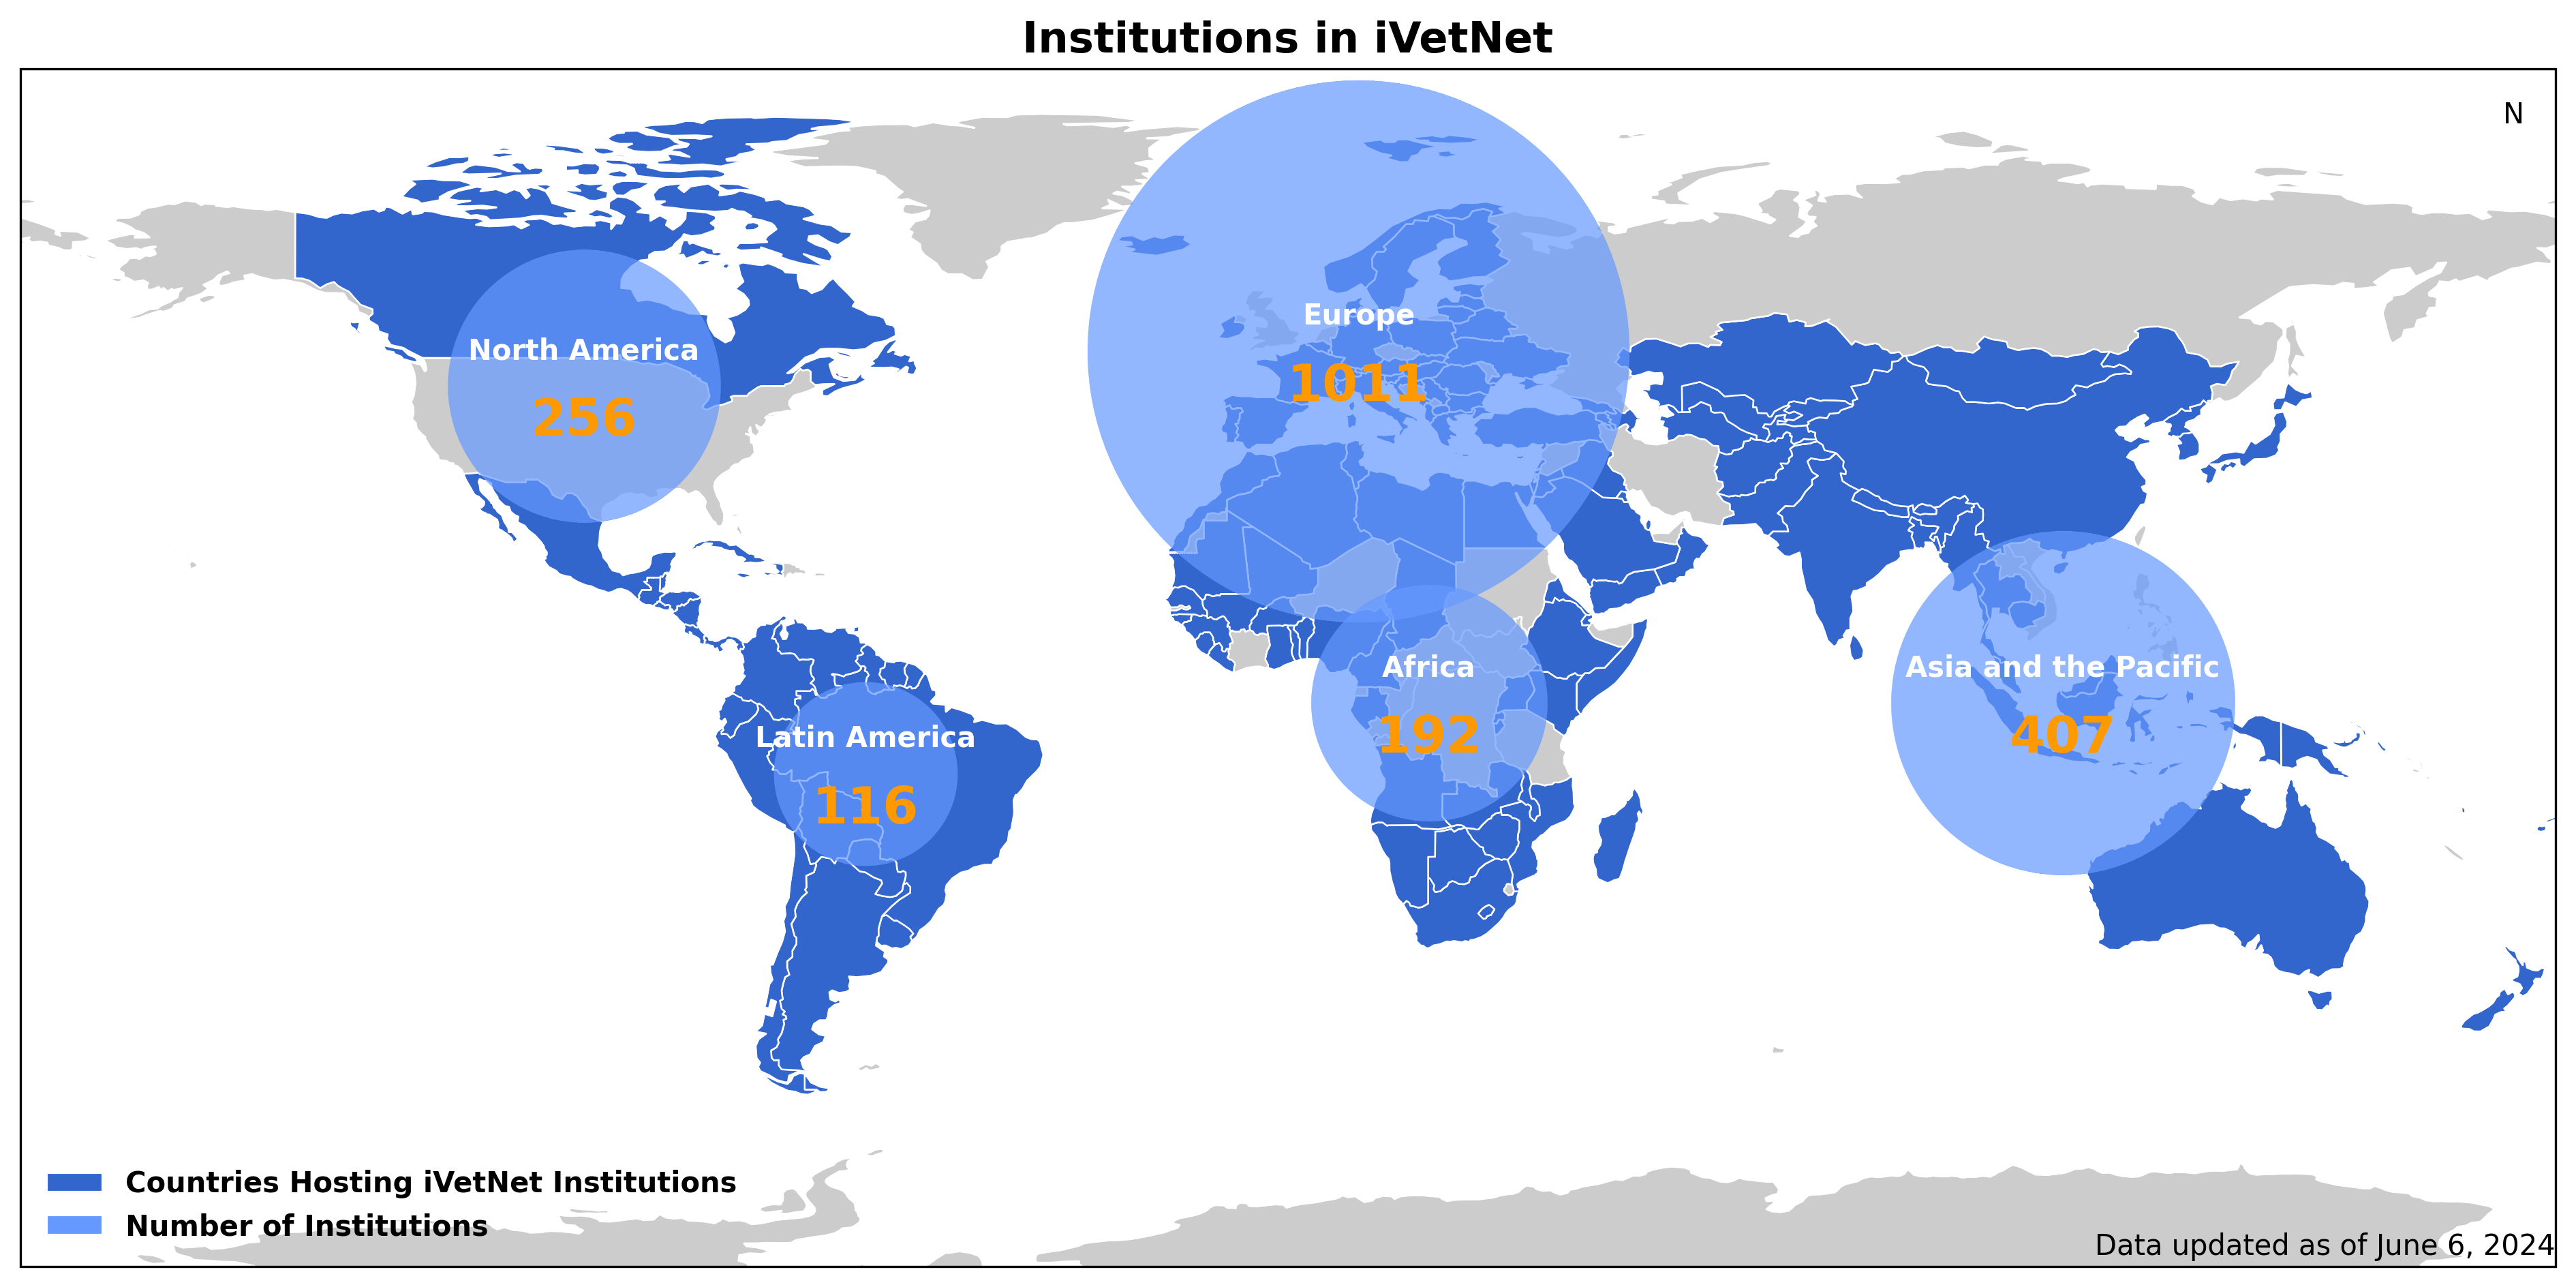

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text
bubble_color = '#6699ff'
text_color = 'white'
highlighted_country_color = '#3366cc'
default_country_color = '#cccccc'
text_color2 = '#ff9900'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.7, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=10, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries Hosting iVetNet Institutions'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of Institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Institutions in iVetNet', size=15, weight='bold')
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# 添加更新日期
update_text = 'Data updated as of June 6, 2024'
ax.text(1, 0.01, update_text, transform=ax.transAxes, fontsize=10, ha='right')


# save image
plt.savefig('/content/drive/MyDrive/figures/locations_of_institutions3.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [40]:
!pip install pandas geopandas matplotlib plotly wordcloud
!apt-get install -y ttf-mscorefonts-installer
!fc-cache -f -v
!apt-get install -y fonts-arial

# Step 2: Google Drive
from google.colab import drive
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ttf-mscorefonts-installer is already the newest version (3.8ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/msttcorefonts: caching, new cache contents: 0 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/

   Institution ID                                   Institution Name  \
0              14  Friedrich-Loeffler-Institute (FLI) - Jena;Fede...   
1             119  Ministry of Agriculture (MOA) and Rural Develo...   
2             119  Ministry of Agriculture (MOA) and Rural Develo...   
3             191        Minister of Agriculture;Veterinary Services   
4             423  Institute for Livestock Research and Developme...   

                                    Address                 Place  \
0                       Naumburger Str. 96a            07743 Jena   
1  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
2  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
3                       30 rue Alain Savary  1002 Tunis Belvédère   
4                     Farcha street; BP 433             N'Djamena   

  Country Name Iaea Region Name         Participant Name Gender Date Of Birth  \
0      Germany           Europe       SEYBOLDT Christian   Male        

<ipython-input-57-33c5257750f1>:15: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



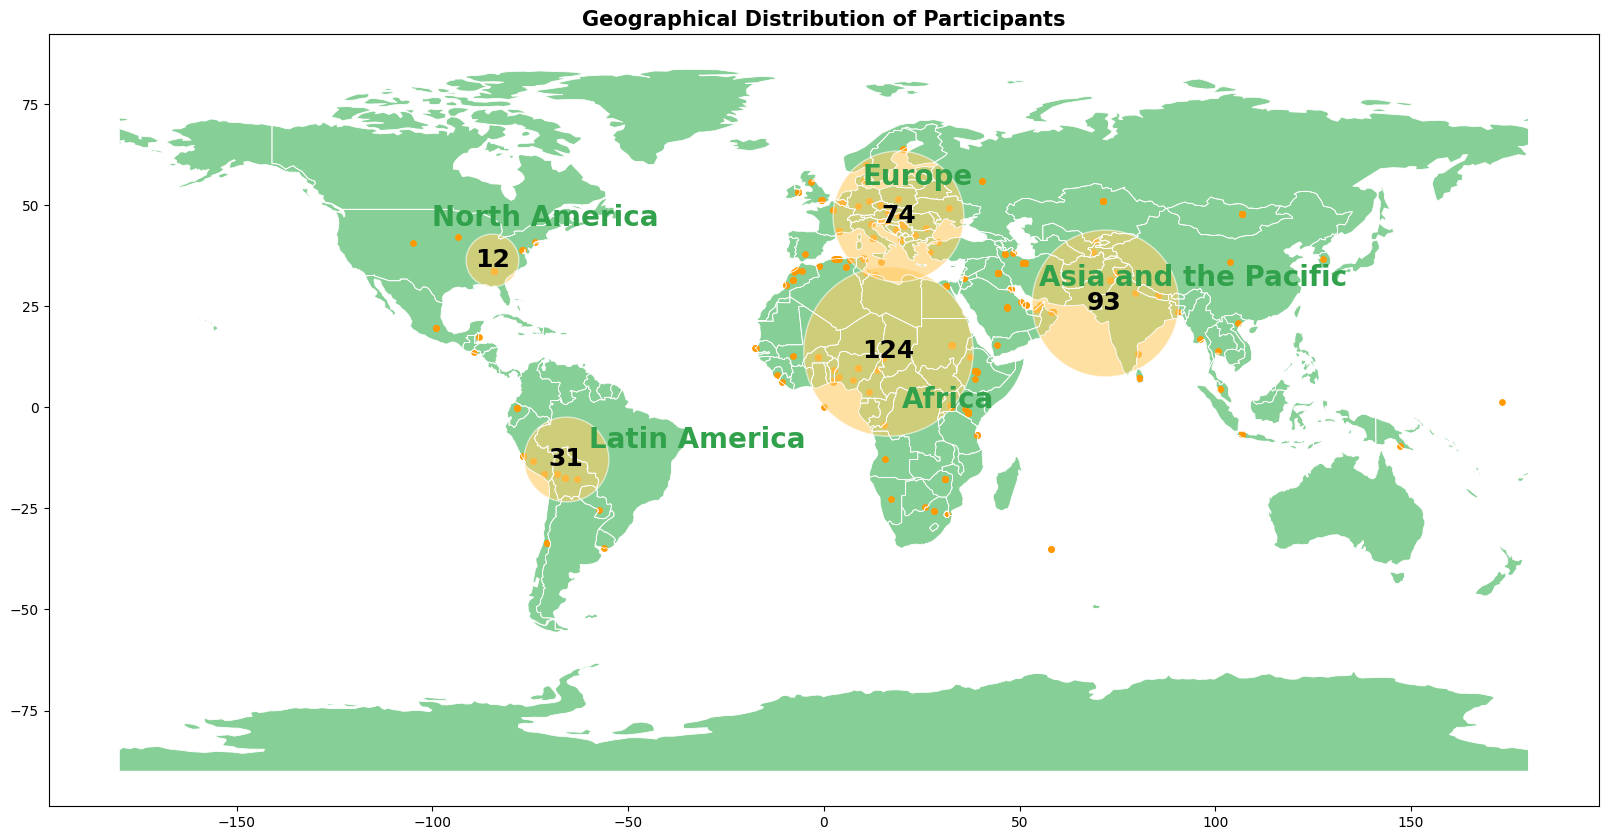

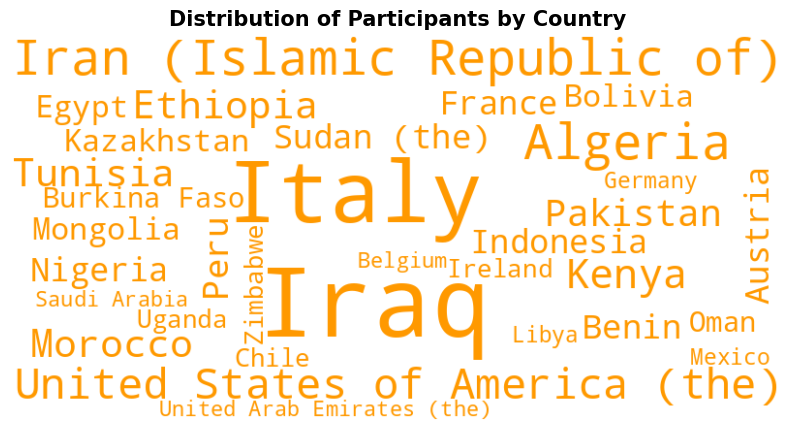

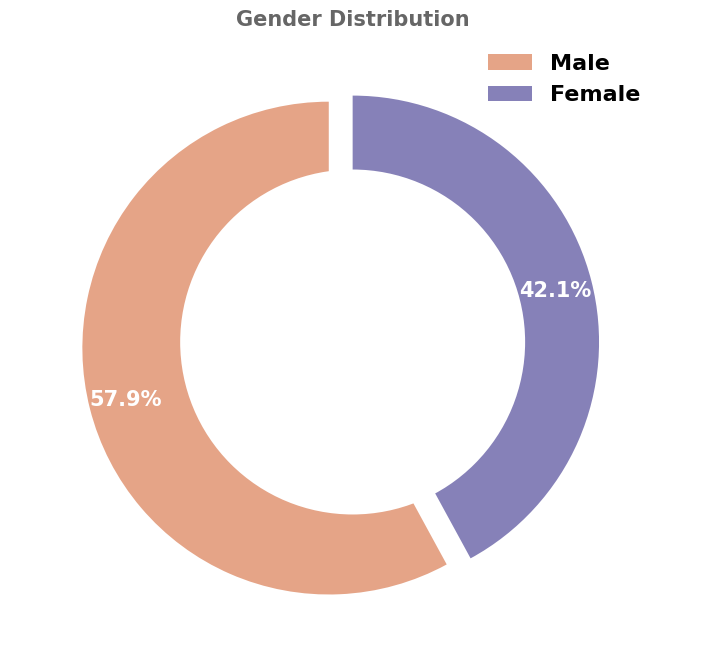

In [57]:
# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/Event Participants.xlsx'
df = pd.read_excel(file_path)
print(df.head())


# 1. Geographical Map using Geopandas with additional features
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Institution Longitude'], df['Institution Latitude']),
    crs="EPSG:4326"
)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

world.boundary.plot(ax=ax, linewidth=0.6, color='white')
world.plot(ax=ax, color='#86cf97')
gdf.plot(ax=ax, color='#ff9900', markersize=15)

# Define the coordinates for each region
continents = {
    'North America': (-100, 45),
    'Asia and the Pacific': (55, 30),
    'Europe': (10, 55),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

for continent, (x, y) in continents.items():
    plt.text(x, y, continent, fontsize=20, color='#32a14c', weight='bold')

# Adding participant counts per region as bubbles
region_counts = df['Iaea Region Name'].value_counts()
for region, count in region_counts.items():
    region_data = df[df['Iaea Region Name'] == region]
    mean_lat = region_data['Institution Latitude'].mean()
    mean_lon = region_data['Institution Longitude'].mean()
    plt.scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color='#ffcc66', edgecolors='white')
    plt.text(mean_lon, mean_lat, str(count), fontsize=18, color='black', ha='center', va='center', weight='bold')

plt.title('Geographical Distribution of Participants', fontname='Arial', size=15, weight='bold')
plt.show()

# 2. Word Cloud for distribution of participants by country
from wordcloud import WordCloud

country_counts = df['Country Name'].value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      color_func=lambda *args, **kwargs: '#ff9900',
                      max_font_size=100, min_font_size=20).generate_from_frequencies(country_counts)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Distribution of Participants by Country', fontname='Arial', size=15, weight='bold')
plt.show()

# 4. Pie Chart for gender distribution
gender_counts = df['Gender'].value_counts()

# Setting up the colors
colors = ['#e5a487', '#8681b8']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, pctdistance=0.85, textprops={'fontsize': 15, 'fontweight': 'bold', 'color': 'white', 'fontname':'Arial'})

# Draw center circle for 'donut' effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Gender Distribution', color='#666666', fontname='Arial', size=15, weight='bold')

# Add legend
plt.legend(labels=['Male', 'Female'], loc="upper right", fontsize=16, frameon=False, prop={'size': 16, 'weight': 'bold', 'family': 'Georgia'})

plt.show()